In [285]:
import os
import numpy as np
from scipy.sparse import csc_matrix, save_npz, load_npz
import re
import pickle
import pandas as pd
from datetime import datetime
from gensim.corpora import Dictionary
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
import nltk
from bs4 import BeautifulSoup
from contractions import contractions_dict
import unicodedata

Using TensorFlow backend.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-285-0704b62a1e6e>", line 18, in <module>
    import keras
  File "//anaconda3/lib/python3.7/site-packages/keras/__init__.py", line 3, in <module>
    from . import utils
  File "//anaconda3/lib/python3.7/site-packages/keras/utils/__init__.py", line 6, in <module>
    from . import conv_utils
  File "//anaconda3/lib/python3.7/site-packages/keras/utils/conv_utils.py", line 9, in <module>
    from .. import backend as K
  File "//anaconda3/lib/python3.7/site-packages/keras/backend/__init__.py", line 1, in <module>
    from .load_backend import epsilon
  File "//anaconda3/lib/python3.7/site-packages/keras/backend/load_backend.py", line 90, in <module>
    from .tensorflow_backend import *
  File "//anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", li

KeyboardInterrupt: 

In [79]:
# 18 fields expected.
field_names = ['id', 'type', 'is_best_answer', 'topic_id', 'parent_id', 'votes',
               'title', 'content', 'member', 'category', 'state', 'is_solved', 'num_answers',
               'country', 'date', 'last_answer_date', 'author_crc', 'visits']

# Read in data

In [475]:
df = pd.read_csv('export-forums_en.csv', error_bad_lines=False)

b'Skipping line 82773: expected 18 fields, saw 19\n'
b'Skipping line 148296: expected 18 fields, saw 19\nSkipping line 150160: expected 18 fields, saw 22\n'
b'Skipping line 208596: expected 18 fields, saw 19\nSkipping line 221196: expected 18 fields, saw 19\n'
b'Skipping line 289838: expected 18 fields, saw 19\n'
b'Skipping line 303102: expected 18 fields, saw 19\nSkipping line 303252: expected 18 fields, saw 20\nSkipping line 303253: expected 18 fields, saw 19\nSkipping line 303254: expected 18 fields, saw 21\nSkipping line 303433: expected 18 fields, saw 19\nSkipping line 303453: expected 18 fields, saw 21\nSkipping line 303474: expected 18 fields, saw 19\nSkipping line 318882: expected 18 fields, saw 19\n'
b'Skipping line 341159: expected 18 fields, saw 19\n'
b'Skipping line 373321: expected 18 fields, saw 19\nSkipping line 374230: expected 18 fields, saw 20\nSkipping line 374231: expected 18 fields, saw 27\n'
b'Skipping line 399960: expected 18 fields, saw 19\nSkipping line 415105:

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,2,3,4,5,8,9,10,11,12,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [476]:
df.columns = ['id', 'type', 'is_best_answer', 'topic_id', 'parent_id', 'votes',
               'title', 'content', 'member', 'category', 'state', 'is_solved', 'num_answers',
               'country', 'date', 'last_answer_date', 'author_crc', 'visits']

In [477]:
#remove comments
df_QA = df[df['type']!='C']

In [478]:
len(df_QA)

634600

# Clean Data

In [287]:
import numpy as np
import pandas as pd
import re
from gensim.corpora import Dictionary
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import nltk
from bs4 import BeautifulSoup
from contractions import contractions_dict
import unicodedata

In [480]:
def clean_data():
    pd.options.mode.chained_assignment = None  # default='warn'
    stemmer = SnowballStemmer("english")
    stop = nltk.corpus.stopwords.words('english')
    stop.remove('no')
    stop.remove('not')
    stop.remove('but')
    stop.append("br")
    stop.append("n")
    toktok = nltk.tokenize.toktok.ToktokTokenizer()
    def expand_contractions(text, contraction_mapping=contractions_dict):
    
        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                          flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contraction_mapping.get(match)\
                                    if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())  
            if expanded_contraction is None:
                expanded_contraction=""
            else:
                expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction

        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text
    def remove_accented_chars(text):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text
    
    df_QA['content'] = df['content'].astype(str)
    #for col_name in ["title", "question", "answer", "comments"]:
        #delete html text/format
    df_QA['content'] = df_QA['content'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
        #remove accented characters eg. "Sómě Áccěntěd těxt" to "Some Accented text"
    df_QA['content'] = df_QA['content'].apply(lambda x: remove_accented_chars(x))
        # expand contracted words eg. "we'll" to "we all", "you're" to "you are"
    df_QA['content'] = df_QA['content'].apply(lambda x: expand_contractions(str(x)))
        # delete puntuations
    df_QA['content'].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~’”“′‘\\\]',' ',inplace=True,regex=True)
        #delete numbers and certain formats and lowercase
    df_QA['cleaned_content'] = df_QA['content'].apply(lambda x: re.sub(r'[^a-zA-z\s]', ' ', x).lower())
        #delete redundant whitespace
    df_QA['cleaned_content'] = df_QA['cleaned_content'].apply(lambda x: re.sub(' +', ' ', x))
        #tokenizer
    df_QA['cleaned_content'] = df_QA['cleaned_content'].apply(toktok.tokenize)
        # stemmer words and remove stop words
    #df_QA['content'] = df_QA['content'].apply(lambda x: [stemmer.stem(word) for word in x if word not in stop])
    df_QA['cleaned_content'] = df_QA['cleaned_content'].apply(lambda x: [word for word in x if word not in stop])
        #add whitespace between words
    df_QA['cleaned_content'] = df_QA['cleaned_content'].apply(lambda x: " ".join(x))
        #deal none type and empty value
        #df[col_name] = df[col_name].apply(lambda x: "" if x ==" " else ("" if x is None else x))
    # combine question and title content together as question
    #df["question"]=df["title"]+" "+df["question"]
    #df.drop(["title"],axis=1,inplace=True)
    df_QA.to_csv('cleaned',index=False)


In [481]:
clean_data()

//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://pcsupport.about.com/od/fixtheproblem/ht/repairbootini.htm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://usb-fix.blogspot.com.ar/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://www.bilgindir.com/spor-yaris/1518-need-speed-run-limited-edition-2011-clone-dvd-full-indir.html#post2116" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use

//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://m.youtube.com/watch?v=XRKGKHScNCc" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://youtu.be/FR6JA92P_dE" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://forums.gamesforwindows.com/t/7889.aspx" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to 

//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://www.sertpornolar.com/mukemmel-masaj-sonrasi-ne-yapilir.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://www.youtube.com/watch?v=cpvtlabejPY" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://youtu.be/Uoyaikcp7LM" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and

//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://www.networkworld.com/article/2201779/applications/how-to-solve-windows-7-crashes-in-minutes.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://www.youtube.com/watch?v=EISfNFbp5NQ" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://www.youtube.com/channel/UCNjailVfaekJFMLhZz5y8CA" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an H

//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://www.youtube.com/watch?v=uO59tfQ2TbA" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://chuyensangbangdia.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://www.facebook.com/houria.orthophoniste?ref=br_tf" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that

//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://www.imageshack.us/i/pmUoq5mcp" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://ccm.net/forum/affich-888861-casustel#p888862" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://www.toxicmob.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Bea

//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://ccm.net/forum/affich-951823-forgot-gmail-password-lost-recovery-mobile-number" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://mbasic.facebook.com/abwaansomali.dhaqandhawr?_e_pi_=7%2CPAGE_ID10%2C3761784137" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://www.facebook.com/duakashmiri786" looks like a URL. Beautiful Soup is not an HTTP client. You should probably 

//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://www.traveloka.com/hotel/indonesia/fiz-apartemen-margonda-viv-3000010026187?spec=6-12-2017.7-12-2017.1.1.HOTEL.3000010026187.Fiz+Apartemen+Margonda+V&IV_1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://youtu.be/qgn5GtAUGao" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "https://www.youtube.com/watch?v=3Na5hskDfJ4&start_radio=1&list=RD3Na5hskDfJ4" looks like a URL. Be

//anaconda3/lib/python3.7/site-packages/bs4/__init__.py:375: UserWarning: "http://virtuelcampus.univ-msila.dz/facshs" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [482]:
df_QA.head()

,id,type,is_best_answer,topic_id,parent_id,votes,title,content,member,category,state,is_solved,num_answers,country,date,last_answer_date,author_crc,visits,cleaned_content
3,4,Q,0,4,0,1,Windows Vista to XP Downgrading/Reformat?,Hello \r \nI bought a new laptop with Windows ...,0,136,1,1,180,FR,1199900147,1306387514,418598184,4,hello bought new laptop windows vista preinsta...
4,13,A,0,4,4,0,Windows Vista to XP Downgrading/Reformat?,I do not think that they are lying on that one...,0,136,1,1,180,FR,1199952528,1306387514,1932528411,4,not think lying one downgrading would mean tak...
5,47,A,0,4,4,-1,Windows Vista to XP Downgrading/Reformat?,Well you can always downgrade from windows Vis...,0,136,1,1,180,\N,1200476629,1306387514,4185174952,4,well always downgrade windows vista xp but eve...
6,3062,A,0,4,4,-1,Windows Vista to XP Downgrading/Reformat?,i have j ust done the same thing on my hp dv6...,0,136,1,1,180,\N,1206489733,1306387514,489275308,4,j ust done thing hp dv operatingsystem got dri...
7,3701,A,0,4,4,-1,Windows Vista to XP Downgrading/Reformat?,I have just aquired a brand new HP Pavilion dv...,0,136,1,1,180,\N,1207091689,1306387514,3188153141,4,aquired brand new hp pavilion dv want run xp n...


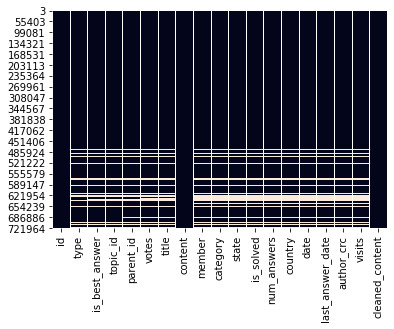

In [484]:
import seaborn as sns
sns.heatmap(df_QA.isnull(), cbar=False) #check for missing data

In [525]:
df_QA = df_QA[df_QA['is_best_answer'].isin([0,1])] #take only values with 0 or 1 for is_best_answer

In [526]:
#convert id and parent_id column to string
df_QA['id'] = df_QA['id'].astype(str)
df_QA['parent_id'] = df_QA['parent_id'].astype(str)

In [553]:
#create list with all question IDs
ids = list(df_QA[df_QA['type']=='Q']['id'])

In [604]:
len(ids)

47315

In [605]:
question_answer = {} #create dictionary to store question and corresponding best answer
for i in range(len(ids)):
    current_set = df_QA[df_QA['id']==ids[i]] #select the next id
    question = current_set[current_set['type']=='Q']['cleaned_content'].iloc[0] #define question
    
    #use answer with value is_best_answer = 1 as best answer, if none, use answer with highest vote
    try:
        best_answer = df_QA[(df_QA['parent_id']==ids[i])&(df_QA['type']=='A')&(df_QA['is_best_answer']==1)]['cleaned_content'].iloc[0]
    except:
        best_answer = df_QA[(df_QA['parent_id']==ids[i])&(df_QA['type']=='A')].max()['cleaned_content'] #define best answer (highest vote)
    
    question_answer.update({question:best_answer})

In [616]:
df = pd.DataFrame(question_answer.items(), columns=['Question', 'Answer'])

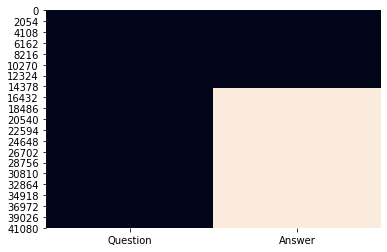

In [617]:
sns.heatmap(df.isnull(), cbar=False) # show missing values

In [618]:
df.dropna(inplace = True) #continue only with data without missing values (could be because there was no answer to question)

In [619]:
len(df) #remaining rows

14731

In [620]:
df.to_csv('cleaned_data.csv') #store in csv file

# Train Doc2Vec model

In [621]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Question'], df['Answer'], random_state = 101, test_size = 0.2)

In [622]:
#Import all required libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [623]:
data = list(X_train)

In [624]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]

In [625]:
max_epochs = 30
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

iteration 0


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29


# Compute the maximum similarity score for each question

In [626]:
#define question that takes the answer with the most similar question (based on cosine similarity score)
def predict_best_answer (text):
    rowindex = int(model.docvecs.most_similar(positive=[model.infer_vector(text.split(' '))],topn=1)[0][0])
    answer = y_train.iloc[rowindex]
    return(answer)

In [628]:
test_df = pd.DataFrame(X_test)

In [602]:
test_df['Predicted Answer'] = test_df['Question'].apply(predict_best_answer)

In [630]:
test_df.to_csv('final_prediction') #store to csv file